# Processing an image of coins

In [1]:
import numpy as np
import scipy.ndimage.filters
import matplotlib.pyplot as plt
from skimage.segmentation import clear_border
from skimage import io
from skimage import data, color
from skimage.measure import label, regionprops
from skimage.color import label2rgb
from skimage.feature import peak_local_max
from skimage.transform import hough_line, hough_line_peaks, hough_circle, hough_circle_peaks, probabilistic_hough_line
from skimage import feature
from skimage.morphology import binary_dilation, binary_erosion

from skimage.draw import circle_perimeter
from skimage.util import img_as_ubyte
from scipy import ndimage as ndi
from skimage.morphology import dilation, erosion, disk,  opening, closing, thin, reconstruction, extrema, binary_closing, binary_opening, watershed
from skimage.filters import sobel, sobel_h, sobel_v, prewitt, prewitt_v, prewitt_h, gaussian
from skimage.filters import rank, threshold_otsu, threshold_local
from skimage import util
from scipy.ndimage.morphology import binary_fill_holes
from skimage.measure import label, regionprops
import matplotlib.patches as patches
from skimage.morphology import remove_small_objects
from skimage import measure
from scipy import signal

###  Subtask 1: Read in the image of coins you have been provided and display it with an appropriate title.

Text(0.5, 1.0, 'Original Image')

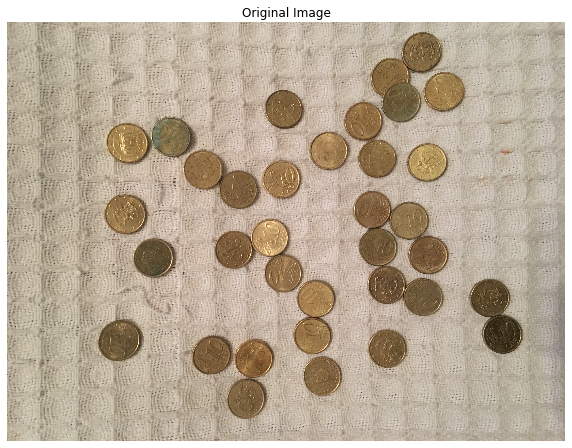

In [2]:
image = io.imread("COINS_4208.JPG")

plt.figure(figsize=(10, 10))
plt.subplot(111)
plt.imshow(image)
plt.axis('off')

plt.title("Original Image")

### Subtask 2:  Display the red, blue and green channels in a subplot. Label each image with the color band.

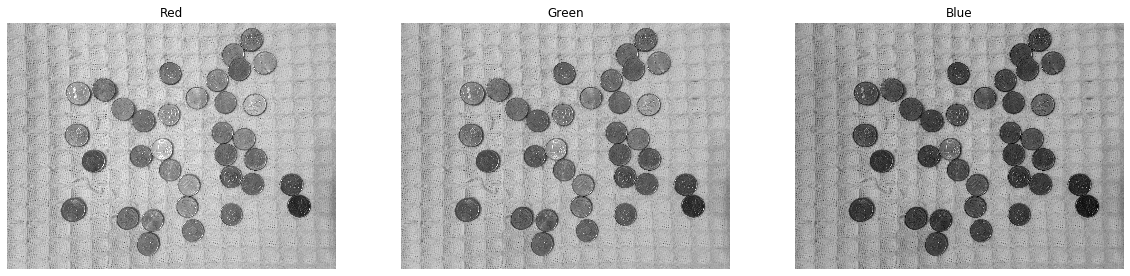

In [3]:
image = io.imread("COINS_4208.JPG")
im_r = image[:, :, 0]
im_g = image[:, :, 1]
im_b = image[:, :, 2]

images = [im_r, im_g, im_b]
channels = ["Red", "Green", "Blue"]
i = 1

plt.figure(figsize=(20, 15))

for image, channel in zip(images, channels):
    plt.subplot(1, 3, int(i))
    i += 1
    plt.axis('off')
    plt.title(channel)
    plt.imshow(np.asarray(image), cmap='gray')


### Subtask 3: Segment the coins to obtain a binary image where pixels representing the coins are set to 1. You should compare two image segmentation algorithms and you can apply morphological operations on these images.

C:\Users\Generic\Anaconda3\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


(-0.5, 4031.5, 3023.5, -0.5)

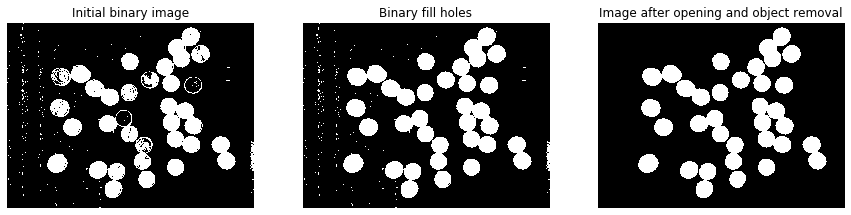

In [4]:
# Algorithm 1 - Thresholding + Morphological operations

image = io.imread("COINS_4208.JPG") # load image
gray_im = color.rgb2gray(image) # convert to gray scale

denoised = rank.median(gray_im, disk(7)) # denoise
binary = denoised < 140 # apply threshold

# apply morphological operations to remove noise and to mark the whole area of the coins
morph_1 = binary_fill_holes(binary, structure=np.ones((10,10)))
morph_2 = binary_opening(morph_1, disk(20))
morph_3 = remove_small_objects(morph_2, 8500, connectivity=1)

plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.imshow(binary, cmap='gray')
plt.title("Initial binary image")
plt.axis('off')

plt.subplot(132)
plt.imshow(morph_1, cmap='gray')
plt.title("Binary fill holes")
plt.axis('off')

plt.subplot(133)
plt.imshow(morph_3, cmap='gray')
plt.title("Image after opening and object removal")
plt.axis('off')

(-0.5, 4031.5, 3023.5, -0.5)

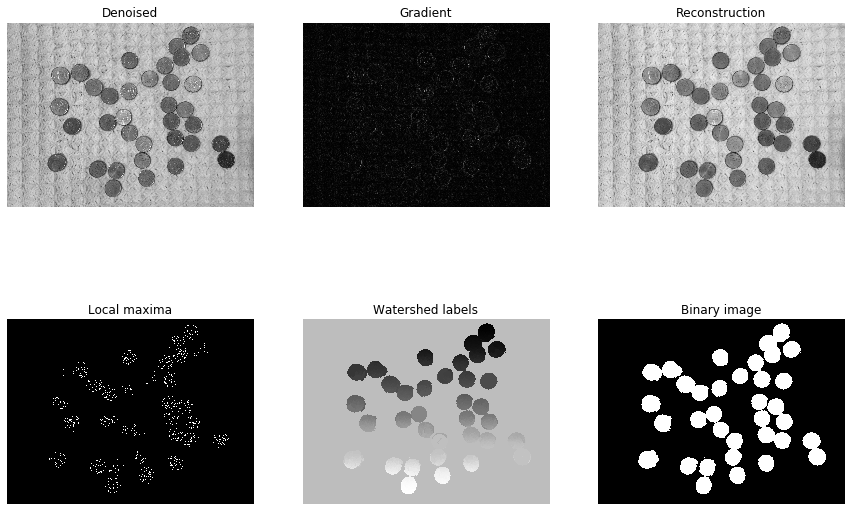

In [5]:
# Algorithm 2 - Watershed
image = io.imread("COINS_4208.JPG") # load image
im = img_as_ubyte(color.rgb2gray(image)) # convert to gray scale

# denoise
denoised = rank.median(gray_im, disk(1))
im_gradient = rank.gradient(denoised, disk(1))

# reconstruct
im_open = opening(denoised,disk(4))
im_erode = erosion(denoised,disk(4))
im_oer  = reconstruction(im_erode,im_open);

# obtain watershed labels
im_foreground =  extrema.h_maxima(im_oer, h=0.01)
label_img = label(im_foreground)
watershed_labels = watershed(im_gradient,label_img);

# remove background
counts = np.bincount(watershed_labels.flatten())
background = np.argmax(counts)
binary = watershed_labels != background

# plot
plt.figure(figsize=(15, 10))

plt.subplot(231)
plt.imshow(denoised, cmap='gray')
plt.title('Denoised')
plt.axis('off')

plt.subplot(232)
plt.imshow(im_gradient, cmap='gray')
plt.title('Gradient')
plt.axis('off')

plt.subplot(233)
plt.imshow(im_oer, cmap='gray')
plt.title('Reconstruction')
plt.axis('off')

plt.subplot(234)
plt.imshow(im_foreground, cmap='gray')
plt.title('Local maxima')
plt.axis('off')

plt.subplot(235)
plt.imshow(watershed_labels, cmap='gray')
plt.title('Watershed labels')
plt.axis('off')

plt.subplot(236)
plt.imshow(binary, cmap='gray')
plt.title('Binary image')
plt.axis('off')

### Subset 4: 4. Using the binary image as input, write code to output a new image containing (a) only the coins which overlap or touch each other (b) only non-overlapping coins.


(-0.5, 4031.5, 3023.5, -0.5)

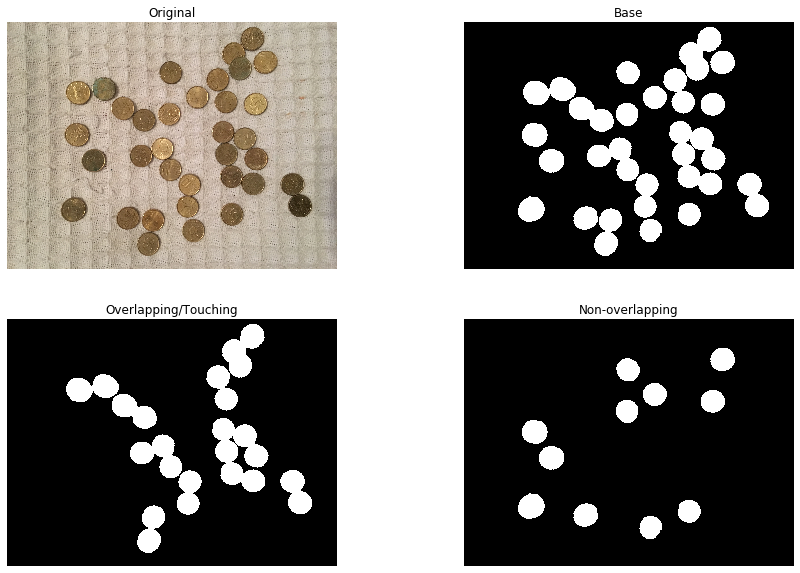

In [6]:
base_image = morph_3

overlapping = remove_small_objects(base_image, 100000, connectivity=1)
nonoverlapping = base_image.astype(float) - overlapping.astype(float)

plt.figure(figsize=(15, 10))

plt.subplot(221)
plt.imshow(image, cmap='gray')
plt.title("Original")
plt.axis('off')

plt.subplot(222)
plt.imshow(morph_3, cmap='gray')
plt.title("Base")
plt.axis('off')

plt.subplot(223)
plt.imshow(overlapping, cmap='gray')
plt.title("Overlapping/Touching")
plt.axis('off')

plt.subplot(224)
plt.imshow(nonoverlapping, cmap='gray')
plt.title("Non-overlapping")
plt.axis('off')


### Subset 5:  Sets of white pixels which are connected to each other are called connected components or objects. Connect all the connected components and separate the touching coins objects.

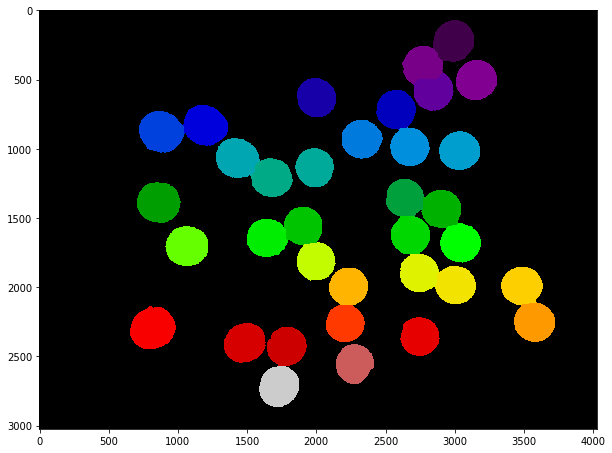

In [7]:
image = morph_3 # load image

distance = ndi.distance_transform_edt(image)
local_maxi = distance > 0.80*distance.max()
markers = ndi.label(local_maxi)[0]

labels = watershed(-distance, markers, mask=image)

plt.figure(figsize=(10,10))
plt.imshow(labels, cmap=plt.cm.nipy_spectral)

### Subset 6: Show your original image with an overlay of bounding boxes or circular boundaries of each object you found. List how many coins your code found.

Coins count: 35


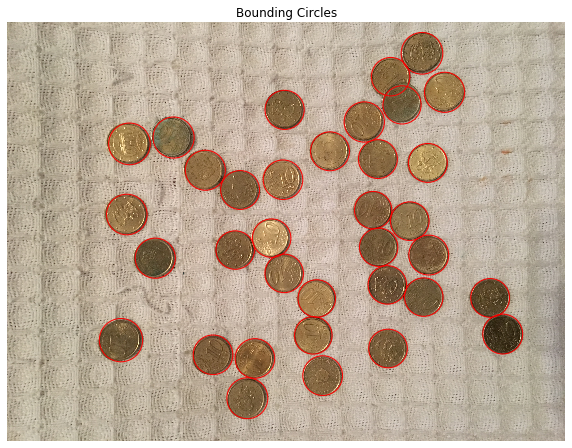

In [8]:
image = io.imread("COINS_4208.JPG")
regions = regionprops(labels)

figure, axis = plt.subplots(1, figsize=(10, 10))
axis.imshow(image, cmap=plt.cm.gray)
axis.axis('off')
plt.title("Bounding Circles")

for props in regions:
    bbox = props.bbox;
    # get the radius and take into account the area lost by the initial erosion
    radius = (bbox[2] - bbox[0])/2
    shape = patches.Circle((props.centroid[1], props.centroid[0]), radius, facecolor='none', edgecolor='red')
    axis.add_patch(shape)

plt.axis('off')
print("Coins count:", len(regions))